In [13]:
from scapy.all import rdpcap, UDP, IP
import datetime
import re
from tqdm import tqdm
from matplotlib import pyplot as plt

def analyse_experiment(pcap_file, entry_file):

    packets = rdpcap(pcap_file)

    entry_timestamps = []
    packet_timestamps = []

    for pkt in tqdm(packets):
        if IP in pkt and UDP in pkt:
            if pkt[IP].dst == "10.0.0.1":
                ts = pkt.time
                ts = float(pkt.time)
                sec = int(ts)
                nsec = int((ts - sec) * 1_000_000_000)

                formatted = f"{datetime.datetime.fromtimestamp(sec).strftime('%H:%M:%S')}.{nsec:09d}"
                packet_timestamps.append(formatted)

    with open(entry_file) as f:
        lines = f.readlines()
        add_lines = []
        timestamps = []
        for line in tqdm(lines):
            if "Adding entry at:" in line:
                add_lines.append(line.strip())
        for line in tqdm(add_lines):
            match = re.search(r"Adding entry at:\s+(\d{2}:\d{2}:\d{2}\.\d+)", line)
            if match:
                timestamp = match.group(1)
                #print("Extracted timestamp:", timestamp)
                timestamps.append(timestamp)
            else:
                print("No timestamp found")
        #print(timestamps)
        entry_timestamps = timestamps
    def to_ns_timestamp(tstr):
        hh, mm, rest = tstr.split(":")
        ss, ns = rest.split(".")
        hh = int(hh)
        mm = int(mm)
        ss = int(ss)
        ns = int(ns)
        total_ns = ((hh*3600 + mm*60 + ss) * 1_000_000_000) + ns
        return total_ns


    entry_ns = [to_ns_timestamp(t) for t in entry_timestamps]
    packet_ns = [to_ns_timestamp(t) for t in packet_timestamps]

    packet_ns.sort()

    latencies = []

    for entry_time in entry_ns:
        first_packet_after_entry = None

        for packet_time in packet_ns:
            if packet_time > entry_time:
                first_packet_after_entry = packet_time
                break

        if first_packet_after_entry is None:
            latencies.append(None)
            continue

        latency = first_packet_after_entry - entry_time
        latencies.append(latency)

    latencies_cleaned = [l for l in latencies if l is not None and l <= 10_000_000]  # Remove None and latencies > 10ms
    latencies_μs = [l / 1_000 for l in latencies_cleaned]  # Convert to microseconds
    plt.plot(latencies_μs)
    plt.xlabel("Messungen Nummer")
    plt.ylabel("Latenz (μs)")
    plt.ylim(0, 8000)
    plt.show()
    print(f"\nDurchschnittliche Latenz: {sum(latencies_cleaned)/len(latencies_cleaned)/1_000:.3f} μs")
    #print(f"Maximale Latenz: {max(latencies_cleaned):.3f} microseconds")
    print(f"Minimale Latenz: {min(latencies_cleaned)/1_000:.3f} μs")

100%|██████████| 89/89 [00:00<00:00, 748082.28it/s]


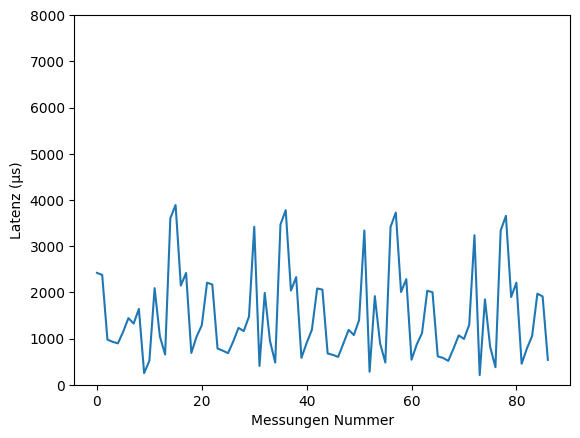


Durchschnittliche Latenz: 1510.250 μs
Minimale Latenz: 207.612 μs


In [14]:
analyse_experiment("measurements/test1.pcap", "measurements/entries_1.txt")

100%|██████████| 304/304 [00:00<00:00, 1109720.12it/s]


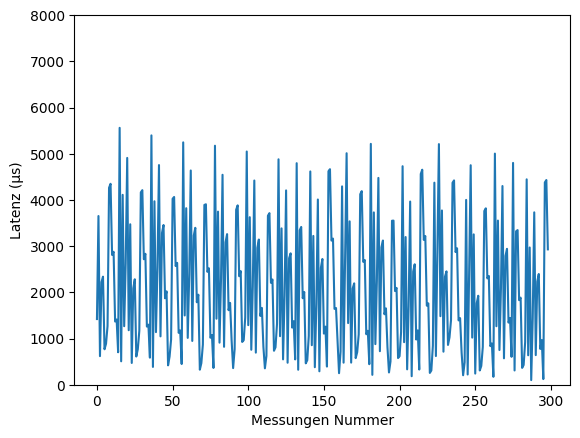


Durchschnittliche Latenz: 2121.268 μs
Minimale Latenz: 99.985 μs


In [15]:
analyse_experiment("measurements/test2.pcap", "measurements/entries_2.txt")

100%|██████████| 30/30 [00:00<00:00, 467766.25it/s]


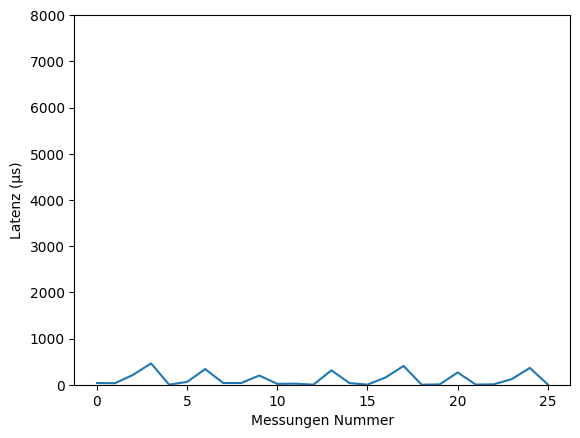


Durchschnittliche Latenz: 121.168 μs
Minimale Latenz: 1.098 μs


In [16]:
analyse_experiment("measurements/test4.pcap", "measurements/entries_4.txt")

100%|██████████| 91/91 [00:00<00:00, 780535.10it/s]


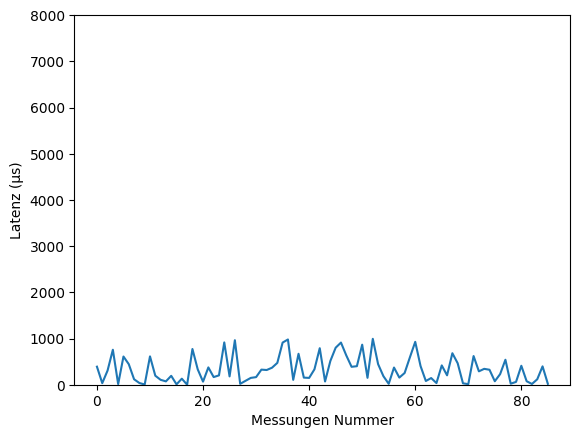


Durchschnittliche Latenz: 333.782 μs
Minimale Latenz: 0.055 μs


In [17]:
analyse_experiment("measurements/test5.pcap", "measurements/entries_5.txt")

100%|██████████| 87/87 [00:00<00:00, 796734.60it/s]


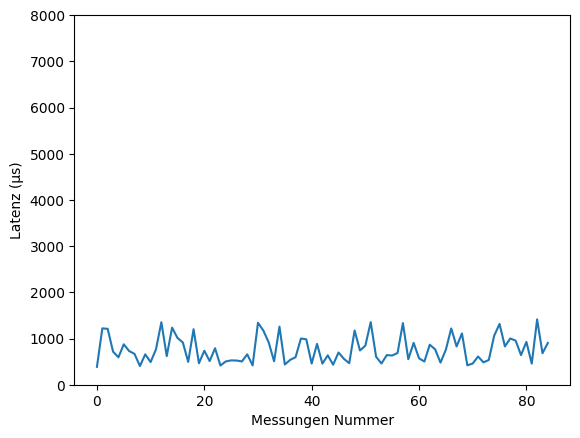


Durchschnittliche Latenz: 760.719 μs
Minimale Latenz: 387.479 μs


In [18]:
analyse_experiment("measurements/test6.pcap", "measurements/entries_6.txt")

100%|██████████| 90/90 [00:00<00:00, 778324.45it/s]


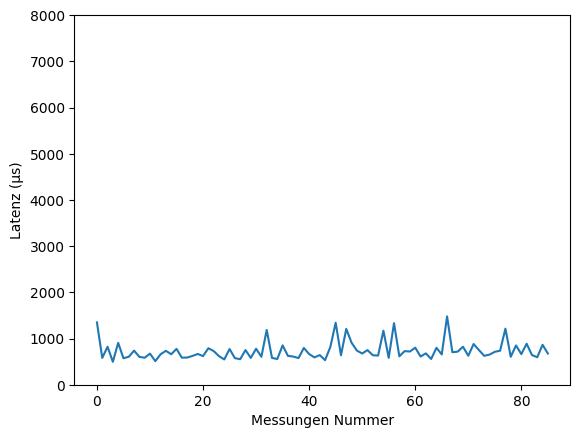


Durchschnittliche Latenz: 734.342 μs
Minimale Latenz: 495.565 μs


In [19]:
analyse_experiment("measurements/test7.pcap", "measurements/entries_7.txt")

100%|██████████| 89/89 [00:00<00:00, 746586.11it/s]


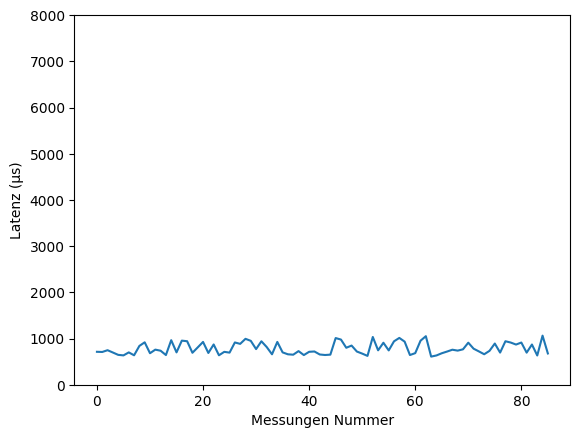


Durchschnittliche Latenz: 783.999 μs
Minimale Latenz: 608.570 μs


In [20]:
analyse_experiment("measurements/test8.pcap", "measurements/entries_8.txt")

100%|██████████| 90/90 [00:00<00:00, 756487.70it/s]


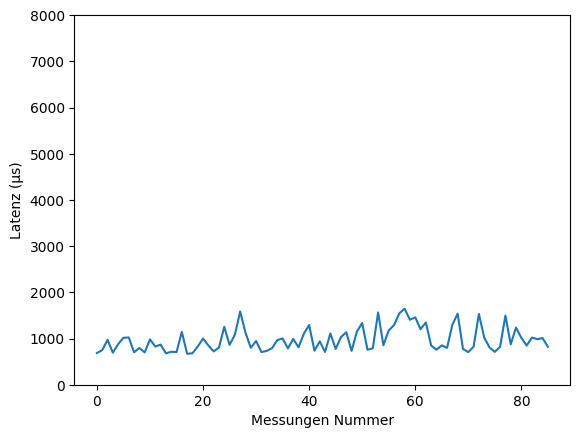


Durchschnittliche Latenz: 974.450 μs
Minimale Latenz: 669.060 μs


In [21]:
analyse_experiment("measurements/test9.pcap", "measurements/entries_9.txt")

100%|██████████| 96/96 [00:00<00:00, 774333.05it/s]


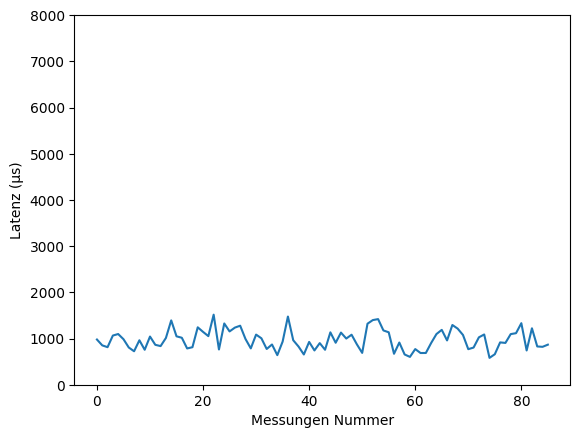


Durchschnittliche Latenz: 972.519 μs
Minimale Latenz: 581.377 μs


In [22]:
analyse_experiment("measurements/test10.pcap", "measurements/entries_10.txt")

100%|██████████| 899/899 [00:00<00:00, 1231041.23it/s]


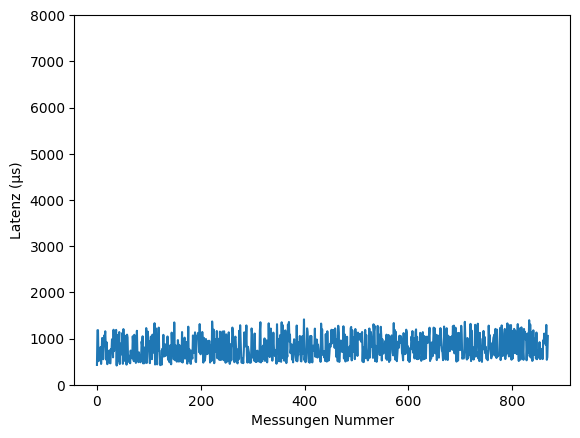


Durchschnittliche Latenz: 814.305 μs
Minimale Latenz: 415.798 μs


In [23]:
analyse_experiment("measurements/test11.pcap", "measurements/entries_11.txt")